# 数据提取工作
从配色方案json中解析出颜色（16进制转8进制rgb格式）

In [1]:
import os
import json
from PIL import Image, ImageDraw
import numpy as np

In [2]:
#convert # FFFFFA to  255,255,250
def huv2num(huv):
#     print(huv)
    try:
        huv = huv.replace('##','#')
        r = int('0x'+ huv[1:3],16)
        g = int('0x'+ huv[3:5],16)
        b = int('0x'+ huv[5:],16)
        return (r,g,b)
    except:
        return None


def parseJson(jsonPath,colors):
    color_sche = []
    color_set = []
    with open(jsonPath,'r',encoding = 'utf-8') as load_color:
        load_dict = json.load(load_color)
        for key, value in load_dict.items():
            try:

                for val in value:
                    val = huv2num(val)
                    color_set.append(val)   
                color = [huv2num(val) for val in value if huv2num(val)]                  
                if len(color) == 5:
                    colors.append(tuple(color))
            except OSError:
                pass

In [3]:
style = os.listdir('你的配色方案的json路径')
colors = []
for name in style:
    jsonPath = os.path.join('你的配色方案的json路径',name)
    if jsonPath.endswith('json'):
        parseJson(jsonPath,colors)

        dir_A = os.path.join('./peisenet_palettes',name.split('.')[0])
        os.makedirs(dir_A)

        for i, color in enumerate(colors):
            im=Image.new('RGB',(1000,1),(0,0,0))
            draw=ImageDraw.Draw(im)
            batch = int(1000 / 5)
            for j, c in enumerate(color):
                if j != 4:
                    draw.rectangle((j*batch,0,(j+1)*batch,1),fill=c)
                else:
                    draw.rectangle((j*batch,0,1000,1),fill=c)

### 这个代码是我的一些额外操作，如果你的数据集符合上述的规则，那么可以忽视

In [4]:
def str2tuple(a):
    b = a.replace('\"','').replace('(','').replace(')','').replace(' ','').split(',')
    return tuple([int(i) for i in b])

# 数据可视化

In [ ]:
img=Image.open('./peisenet_palettes/colorlover/445.jpg')
# img = Image.fromarray(img)
new=img.resize(size=(256,1))
new1 = new.resize(size=(256,30))
plt.imshow(np.array(new))
plt.show()
plt.imshow(np.array(new1))
plt.show()
img.size

In [ ]:
# img=Image.open('./fake_palettes/1213_3_7.jpg')
# # img = Image.fromarray(img)
# new=img.resize(size=(32,1))
# new1 = new.resize(size=(256,30))
# plt.imshow(np.array(new))
# plt.show()
# plt.imshow(np.array(new1))
# plt.show()

# 模型搭建
沿用pix2pix的网络结构来进行训练，一些区别在于输入的size，我是256*1的输入，而不是图像的256*256，输入变小了，所以我增加了通道数，默认第一层就使用了128个通道。

In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
import keras.backend as K
import os
from PIL import Image, ImageDraw
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
gpu_options = tf.GPUOptions(allow_growth=True)
tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


In [3]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=-1, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, nc_out, ndf, max_layers=3):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    

    input_a, input_b = Input(shape=(None, None, nc_in)), Input(shape=(None, None, nc_out))
    _ = Concatenate(axis=-1)([input_a, input_b])
    _ = conv2d(ndf, kernel_size=(1,4), strides=(1,2), padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=(1,4), strides=(1,2), padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D((0,1))(_)
    _ = conv2d(out_feat, kernel_size=(1,4),  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D((0,1))(_)
    _ = conv2d(1, kernel_size=(1,4), name = 'final'.format(out_feat, 1), 
               activation = "sigmoid") (_)    
    return Model(inputs=[input_a, input_b], outputs=_)

In [4]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=128, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=(1,4), strides=(1,2), use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=-1)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=(1,4), strides=(1,2), use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(cropping=((0,0),(1,1)))(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None

    _ = inputs = Input(shape=(1, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [5]:
nc_in = 3
nc_out = 3
ngf = 128
ndf = 128
λ = 10

imageSize = 256
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

netD = BASIC_D(nc_in, nc_out, ndf)
netG = UNET_G(imageSize, nc_in, nc_out, ngf)


# SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))

# netD.summary()
# netG.summary()

In [7]:
real_A = netG.input
fake_B = netG.output
netG_generate = K.function([real_A], [fake_B])
real_B = netD.inputs[1]
output_D_real = netD([real_A, real_B])
output_D_fake = netD([real_A, fake_B])

In [8]:
from keras.optimizers import RMSprop, SGD, Adam

In [ ]:
# 用于断点接着训练
#netD.load_weights('./weights/1000L1_128channel/discriminator/epoch_10.hdf5')
# netG.load_weights('./weights/1000L1_128channel/generator/epoch_10.hdf5')

In [9]:
#loss_fn = lambda output, target : K.mean(K.binary_crossentropy(output, target))
loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))


loss_L1 = K.mean(K.abs(fake_B-real_B))

In [10]:
loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_D/2], training_updates)

In [11]:
loss_G = loss_G_fake   + 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)



# 数据读取函数，用于训练过程的生成器
这里生成过程，原始配色方案作为label，我还会随机黑色涂抹五个颜色区域的某几个区域作为输入，这样来进行训练

In [12]:
def load_data(dataPath):
    dataAB = []
    for root,dirs,files in os.walk(dataPath):
        for f in files:
            if f.endswith('jpg'):
                dataAB.append(os.path.join(root,f))
    random.shuffle(dataAB)
    
    return dataAB[:int(len(dataAB)*0.85)], dataAB[int(len(dataAB)*0.85):]

def read_image(img_name):
    im = Image.open(img_name)
    im_fake = im.copy()
    draw_fake = ImageDraw.Draw(im_fake)
    batch = int(im.size[0] / 5)
    nb = random.randint(1,4)
    index = random.sample([k for k in range(5)],nb)

    for j in range(5):
        if j in index:
            if j != 4:
                draw_fake.rectangle((j*batch,0,(j+1)*batch,1),fill=(0,0,0))
            else:
                draw_fake.rectangle((j*batch,0,im.size[0],1),fill=(0,0,0))

    imgB = im
    imgA = im_fake
    
#     if random.randint(0,1):
#         imgB = Image.fromarray(np.array(im)[:,::-1])
#         imgA = Image.fromarray(np.array(im_fake)[:,::-1])
    
#     print(imgA.shape,imgB.shape)
    outA = np.array(imgA.resize((256,1))) / 255 * 2 - 1
    outB = np.array(imgB.resize((256,1))) / 255 * 2 - 1
    return outA, outB



In [13]:
def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB) * 10
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            random.shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[int(j % len(dataAB))])
#             print(dataAB[j])
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB  

In [14]:
from IPython.display import display
def showX(X, epoch=0, rows=3):

    plt.figure(figsize=(10,5))
    X = np.concatenate(X,1)
    for i in range(rows):
        plt.subplot(2,3,i+1)
        plt.imshow(np.array(Image.fromarray(((X[i]+1)/2*255).clip(0,255).astype('uint8')).resize((512,100))))
    plt.show()
    plt.savefig('results/epoch_{}.jpg'.format(str(epoch)))


    
    
    
        

# 训练数据可视化

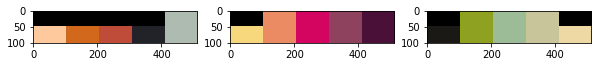

<class 'numpy.ndarray'> (6, 1, 256, 3)


<Figure size 432x288 with 0 Axes>

In [15]:
trainAB, valAB = load_data('./peisenet_palettes/colorlover/')
train_batch = minibatch(trainAB, 6)
_, trainA, trainB = next(train_batch)

showX([trainA,trainB])
_,a,b=train_batch.send(6)
del train_batch, trainA, trainB

# 训练
训练过程中如果按照一次生成器一次判别器的顺序训练，结果会很差，生成结果很槽糕，所以实际训练一个迭代采用了3次生成一次判别

In [16]:
def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

[9/10][110000] Loss_D: 0.298420 Loss_G: 2.529367 loss_L1: 0.180865


<Figure size 432x288 with 0 Axes>

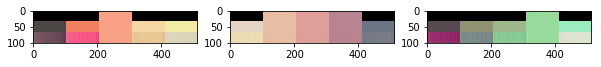

<Figure size 432x288 with 0 Axes>

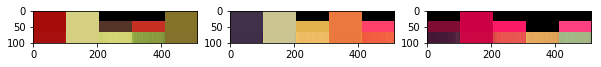

[9/10][112000] Loss_D: 0.292647 Loss_G: 2.654259 loss_L1: 0.180965


<Figure size 432x288 with 0 Axes>

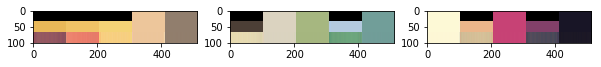

<Figure size 432x288 with 0 Axes>

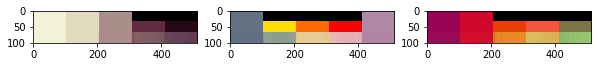

[9/10][114000] Loss_D: 0.307236 Loss_G: 2.577725 loss_L1: 0.179141


<Figure size 432x288 with 0 Axes>

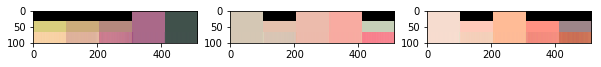

<Figure size 432x288 with 0 Axes>

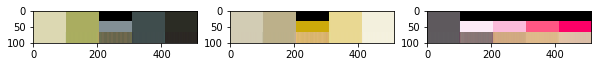

[9/10][116000] Loss_D: 0.283445 Loss_G: 2.629568 loss_L1: 0.176631


<Figure size 432x288 with 0 Axes>

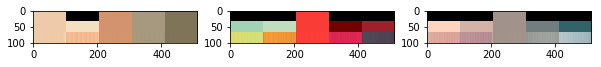

<Figure size 432x288 with 0 Axes>

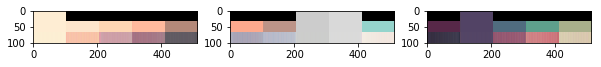

<Figure size 432x288 with 0 Axes>

In [17]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 10
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = 2000
val_batch = minibatch(valAB, 6)
train_batch = minibatch(trainAB, batchSize)
current_iter = 0

while epoch < niter: 
    epoch, trainA, trainB = next(train_batch)        
    errD,  = netD_train([trainA, trainB])
    errD_sum +=errD

    
    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    
    for i in range(3):        
        _, trainA1, trainB1 = next(train_batch)
        errG, errL1 = netG_train([trainA1, trainB1])
        errG_sum += errG
        errL1_sum += errL1
    
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(5*display_iters)==0:
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, niter, gen_iterations, errD_sum/display_iters, errG_sum/(display_iters*4), errL1_sum/(display_iters*4)))
        _, valA, valB = train_batch.send(6) 
        fakeB = netG_gen(valA)
        showX([valA, valB, fakeB], gen_iterations)
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(valA)
        showX([valA, valB, fakeB], gen_iterations)
    if epoch > current_iter:
        current_iter += 1
        netG.save('weights/100L1_128channel_4gen/generator/epoch_{}.hdf5'.format(str(epoch)))
        netD.save('weights/100L1_128channel_4gen/discriminator/epoch_{}.hdf5'.format(str(epoch)))
        

# 测试部分

In [6]:
from keras.models import load_model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(allow_growth=True)
tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
#这里我训练了基于不同参数的三个模型，这里视情况使用
generator = load_model('weights/GAN/100L1_128channel_peisenet/generator/epoch_2.hdf5')
generator1 = load_model('weights/GAN/100L1_128channel_4gen/generator/epoch_10.hdf5')
generator2 = load_model('weights/GAN/1000L1_256channel/generator/epoch_10.hdf5')

/usr/local/lib/python3.6/dist-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
for layer in generator.layers:
    layer.trainable = False

Processing 0 ... 


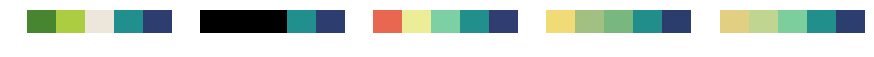

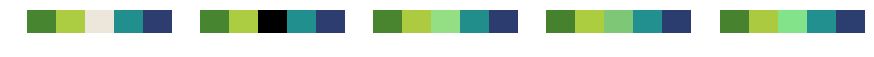

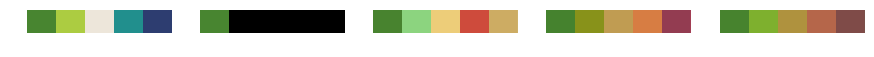

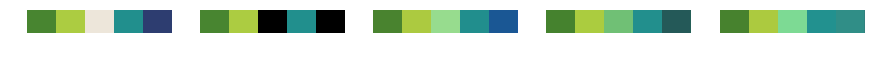

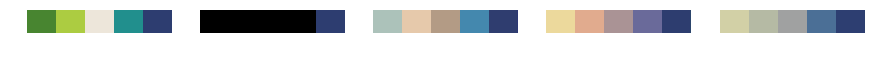

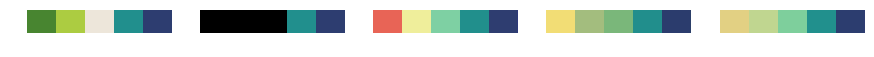

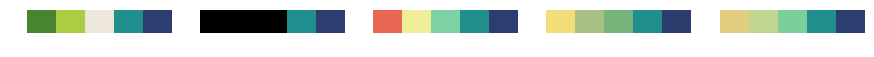

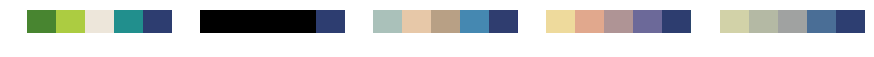

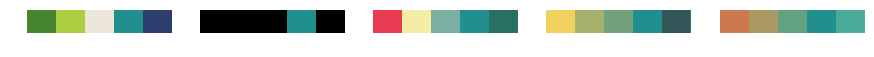

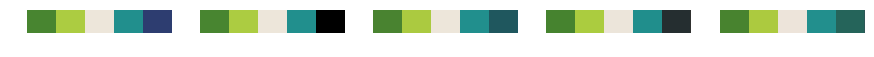

Processing 1 ... 


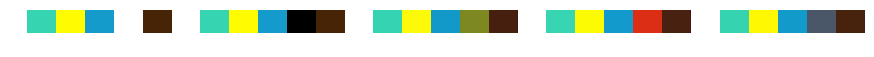

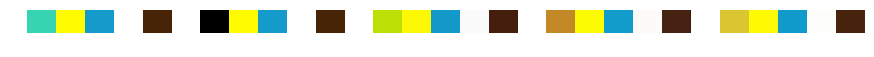

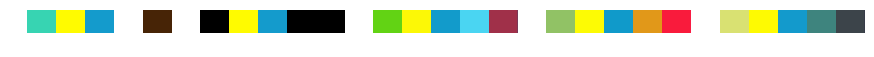

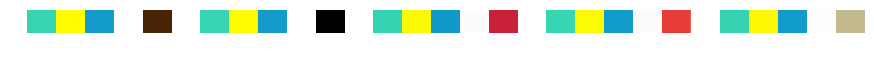

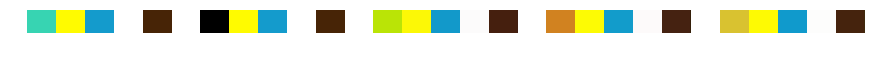

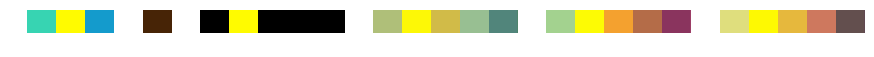

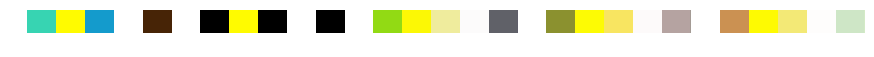

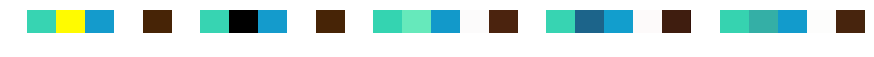

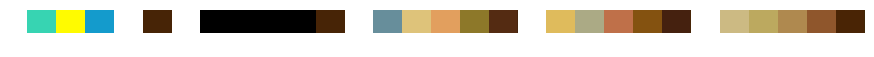

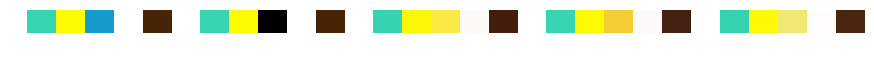

Processing 2 ... 


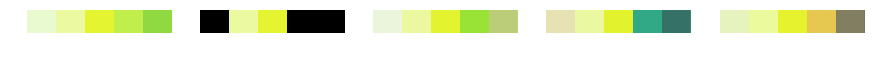

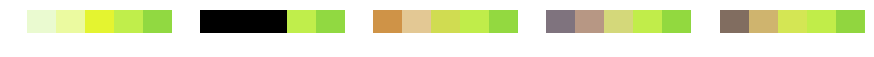

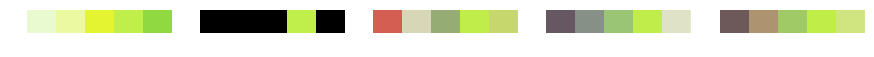

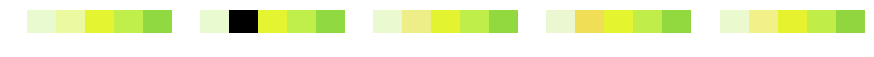

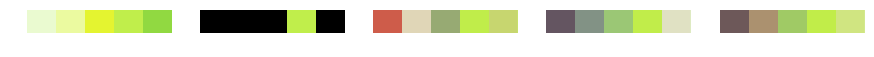

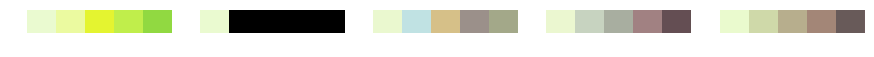

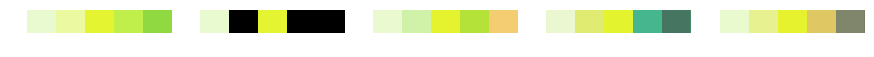

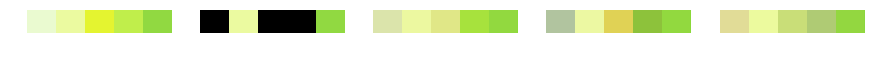

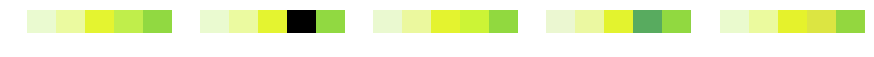

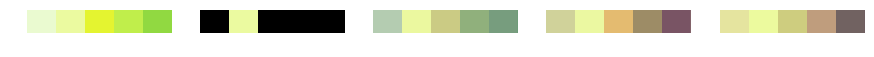

Processing 3 ... 


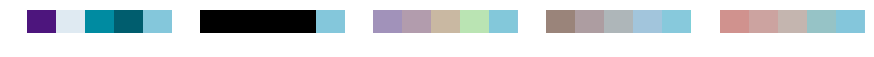

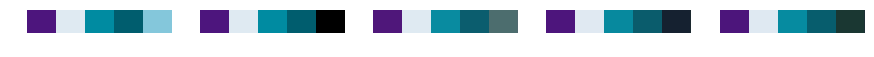

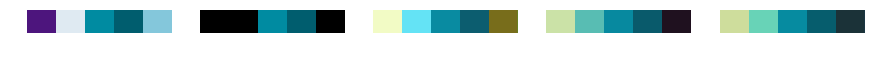

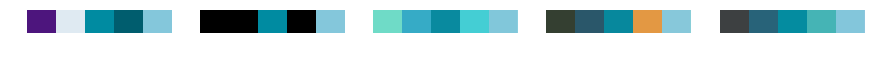

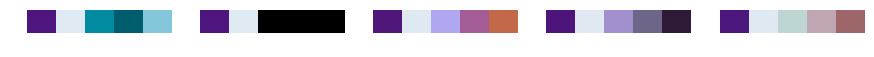

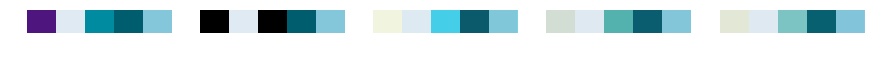

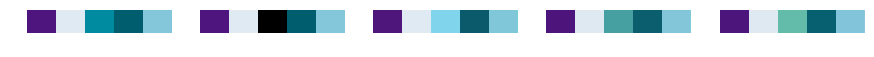

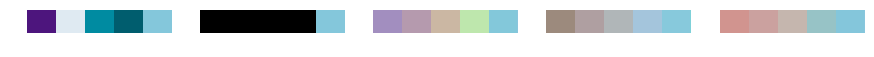

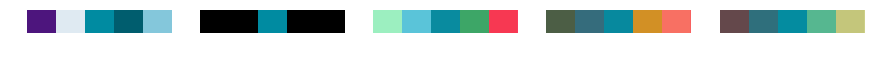

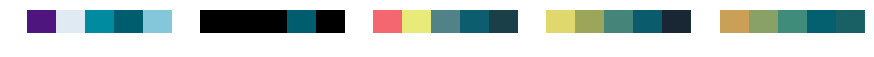

Processing 4 ... 


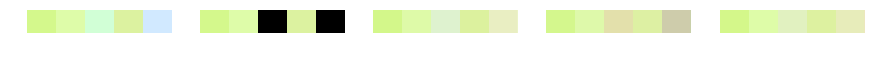

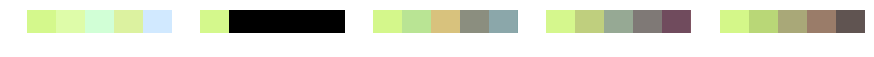

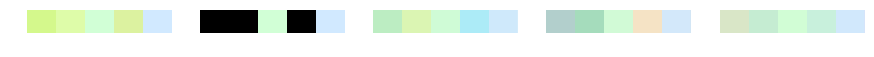

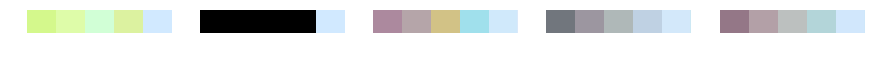

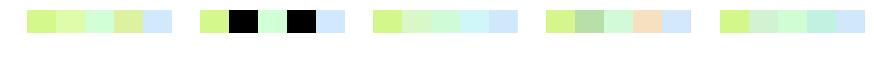

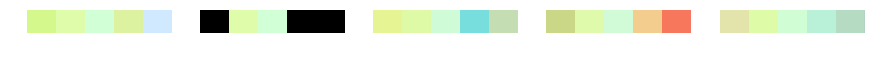

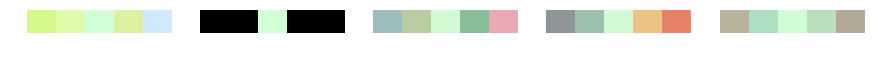

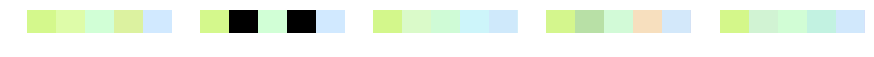

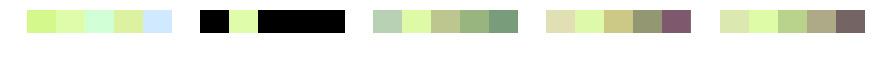

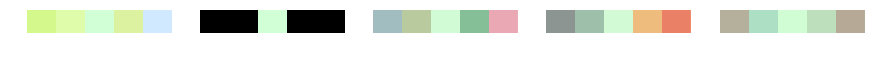

Processing 5 ... 


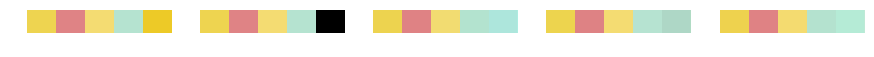

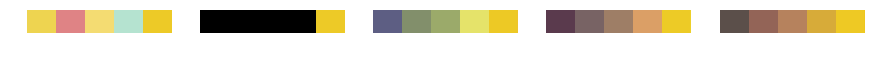

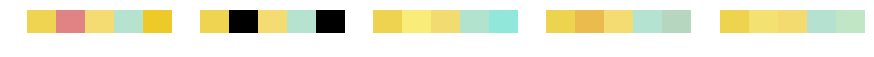

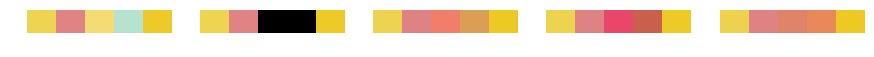

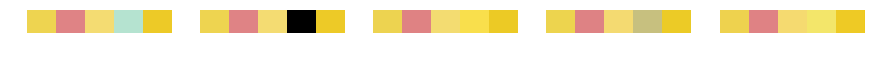

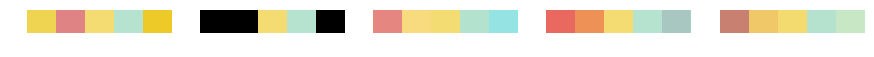

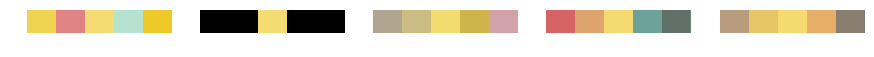

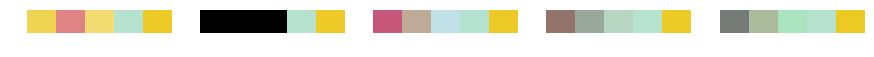

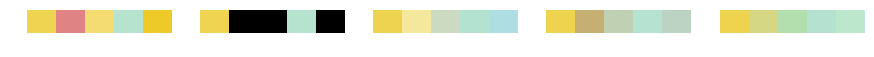

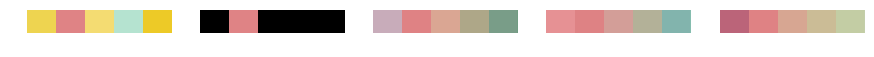

Processing 6 ... 


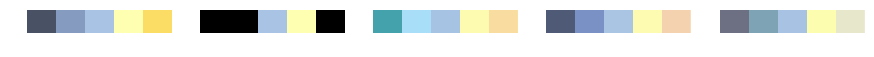

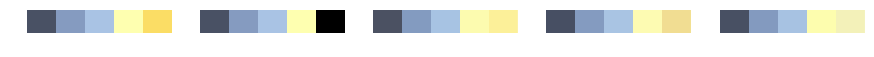

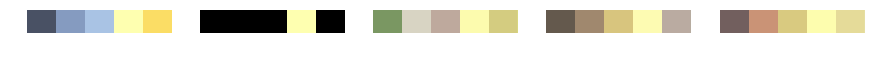

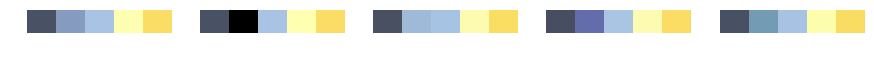

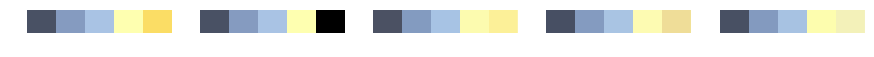

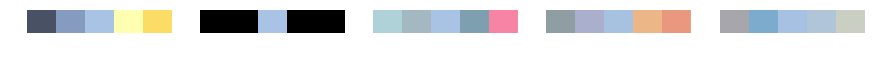

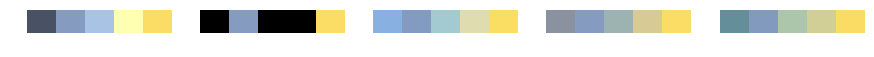

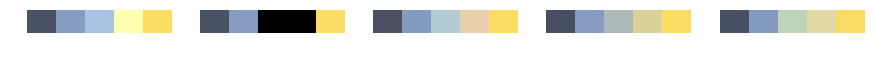

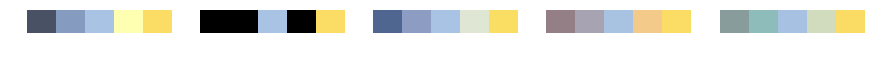

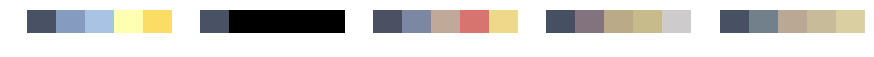

Processing 7 ... 


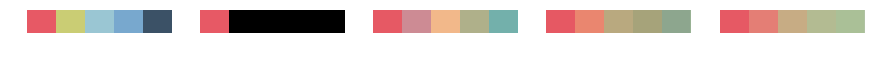

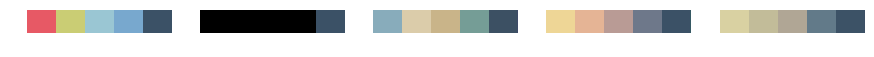

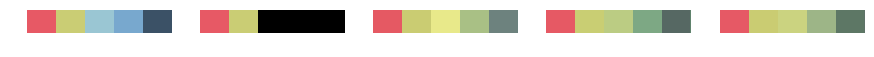

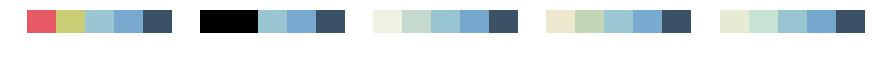

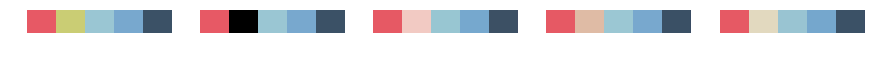

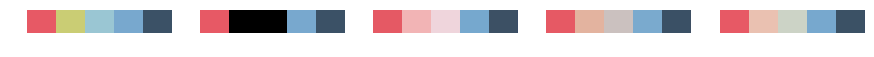

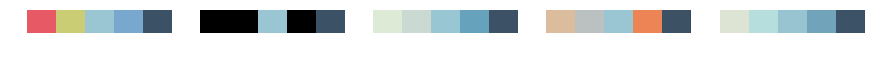

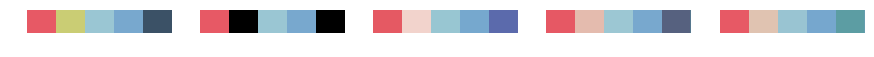

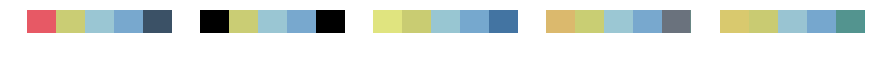

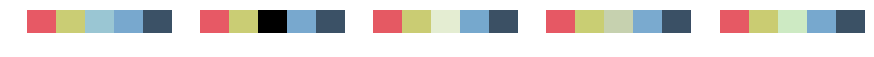

Processing 8 ... 


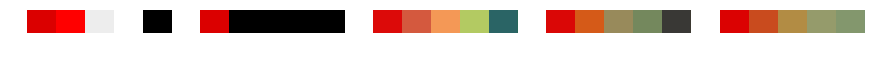

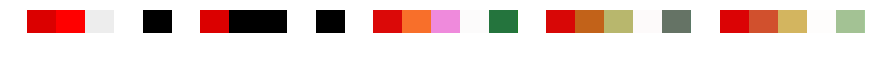

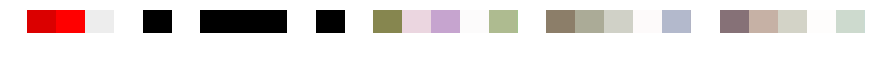

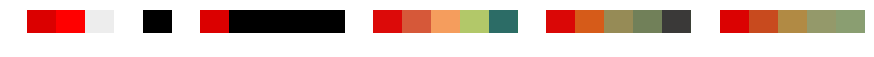

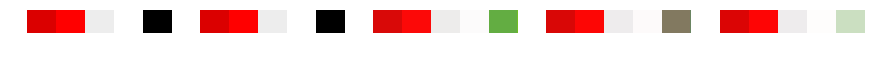

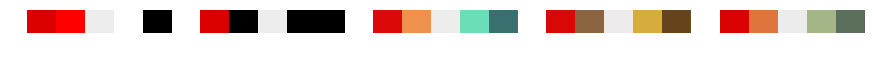

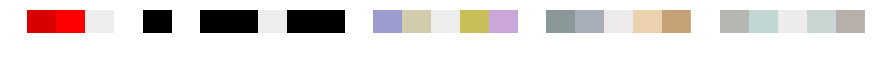

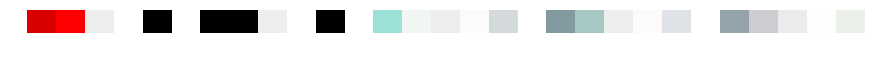

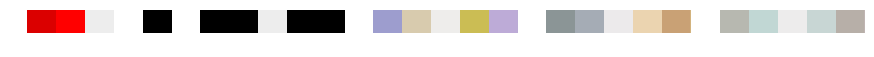

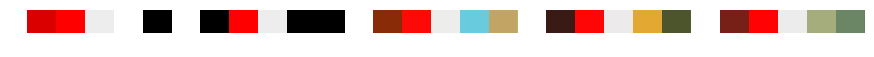

Processing 9 ... 


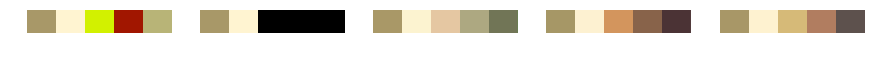

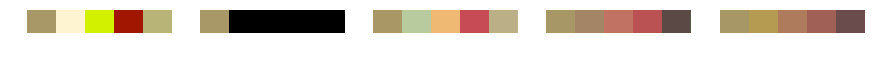

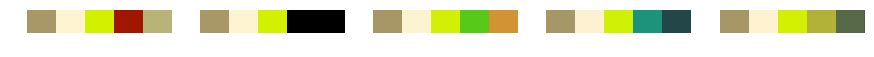

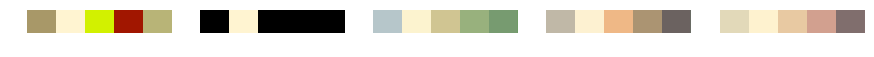

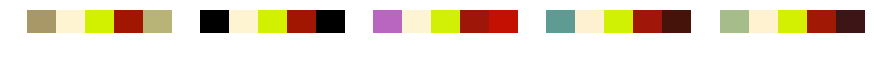

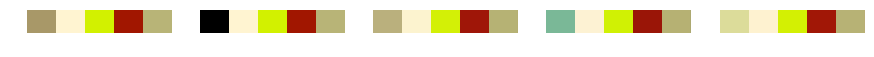

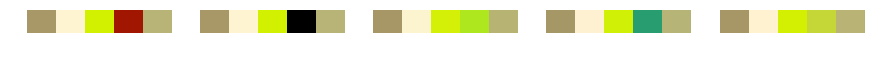

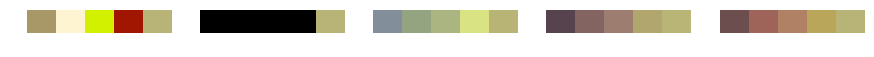

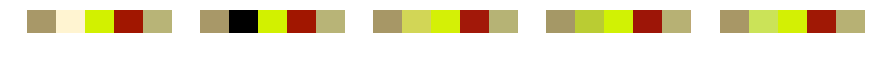

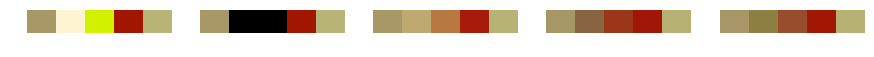

In [11]:
from copy import deepcopy
import random
random.shuffle(colors)
# color = colors[100]
for i,color in enumerate(colors[:10]):
    print('Processing {} ... '.format(str(i)))

    # color = [(212,123,80) for _ in range(8)]
    batch = int(256 / 5)
    for _ in range(10):
        img = Image.new("RGB",(256,1),(0,0,0))
        im = np.array(img)
        im_fake = np.array(img)
        nb = random.randint(1,4)
        index = random.sample([k for k in range(5)],nb)
        for j, c in enumerate(color):
    #         print(c)
            if j not in index:
                if j == len(color)-1:
                    im_fake[:,j*batch:,:] = c
                else:
                    im_fake[:,j*batch:(j+1)*batch,:] = c

            if j == len(color)-1:
                im[:,j*batch:,:] = c
            else:
                im[:,j*batch:(j+1)*batch,:] = c


        plt.figure(figsize=(15,15))

        plt.subplot(1,5,1)
        plt.imshow(np.array(Image.fromarray(im).resize((512,80))))
        plt.axis('off')

        plt.subplot(1,5,2)
        plt.imshow(np.array(Image.fromarray(im_fake).resize((512,80))))
        plt.axis('off')

        result = generator.predict(np.expand_dims(im_fake / 255 * 2 - 1,0))[0]
        result1 = generator1.predict(np.expand_dims(im_fake / 255 * 2 - 1,0))[0]
        result2 = generator2.predict(np.expand_dims(im_fake / 255 * 2 - 1,0))[0]
        for i in range(5):
            result[:,i*batch:(i+1)*batch,:] = np.mean(result[:,i*batch:(i+1)*batch,:],1)[0]
            result1[:,i*batch:(i+1)*batch,:] = np.mean(result1[:,i*batch:(i+1)*batch,:],1)[0]
            result2[:,i*batch:(i+1)*batch,:] = np.mean(result2[:,i*batch:(i+1)*batch,:],1)[0]
        plt.subplot(1,5,3)
        res = np.array(Image.fromarray(((result+1)/2*255).clip(0,255).astype('uint8')).resize((512,80)))
        plt.imshow(res)
        plt.axis('off')

        plt.subplot(1,5,4)
        res1 = np.array(Image.fromarray(((result1+1)/2*255).clip(0,255).astype('uint8')).resize((512,80)))
        plt.imshow(res1)
        plt.axis('off')

        plt.subplot(1,5,5)
        res2 = np.array(Image.fromarray(((result2+1)/2*255).clip(0,255).astype('uint8')).resize((512,80)))
        plt.imshow(res2)
        plt.axis('off')
    
    
    
    plt.show()

        
                


                    